<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/OneClassSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# One-Class SVM (RBF) による異常検知
# 手順:
# 1) 2次元の相関ありガウスから「学習=正常」、テストに「正常+異常」を作成
# 2) 学習統計量で Z 標準化
# 3) OCSVM を学習（RBF）。decision_function を反転して「大きいほど異常」スコア化
# 4) 学習スコアの上位 α 分位点でしきい値 → テスト判定
# 5) 散布図＋等高線、スコアのヒストを表示

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

In [2]:
np.random.seed(0)


In [3]:
# ===== パラメータ =====
alpha = 0.99     # 学習スコアの上位 α 分位点をしきい値に
nu = 0.05        # OCSVM の「外れ率」目安（0.01〜0.1で調整）
gamma = "scale"  # RBFのγ（"scale" でOK）
n_train = 400
n_test_norm = 200
n_test_out  = 20

In [4]:
# ===== データ作成 =====
mu = np.array([0.0, 0.0])
Sigma = np.array([[3.0, 2.0],[2.0, 5.0]])
train = np.random.multivariate_normal(mu, Sigma, size=n_train)
test_norm = np.random.multivariate_normal(mu, Sigma, size=n_test_norm)
mu_out = np.array([6.0, -6.0])
Sigma_out = np.array([[1.0, 0.2],[0.2, 1.0]])
test_out = np.random.multivariate_normal(mu_out, Sigma_out, size=n_test_out)
test = np.vstack([test_norm, test_out])
labels = np.hstack([np.zeros(len(test_norm), int), np.ones(len(test_out), int)])

In [5]:
# ===== 標準化（学習統計量のみ）=====
mu_hat = train.mean(axis=0)
std_hat = train.std(axis=0, ddof=1)
std_hat = np.where(std_hat==0, 1.0, std_hat)
train_z = (train - mu_hat)/std_hat
test_z  = (test  - mu_hat)/std_hat

In [6]:
# ===== 学習 & スコア =====
ocsvm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
ocsvm.fit(train_z)

# sklearn の decision_function は「大きいほど正常」→ 反転して「大きいほど異常」に統一
score_train = -ocsvm.decision_function(train_z).ravel()
score_test  = -ocsvm.decision_function(test_z).ravel()

# しきい値（学習スコアの上位 α 分位点）
finite_train = np.isfinite(score_train)
thr = np.quantile(score_train[finite_train], alpha)
pred = (score_test > thr).astype(int)


In [7]:
# ===== 集計 =====
tp = ((pred==1)&(labels==1)).sum()
fp = ((pred==1)&(labels==0)).sum()
fn = ((pred==0)&(labels==1)).sum()
precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
print(f"[OCSVM] alpha={alpha}, nu={nu}, gamma={gamma}")
print(f"threshold (train quantile): {thr:.4f}")
print(f"TP={tp}, FP={fp}, FN={fn}")
print(f"precision={precision:.3f}, recall={recall:.3f}")

[OCSVM] alpha=0.99, nu=0.05, gamma=scale
threshold (train quantile): 0.1384
TP=20, FP=4, FN=0
precision=0.833, recall=1.000


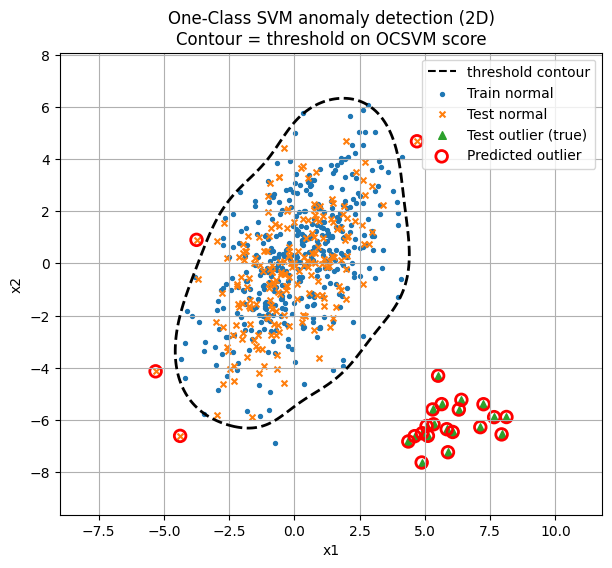

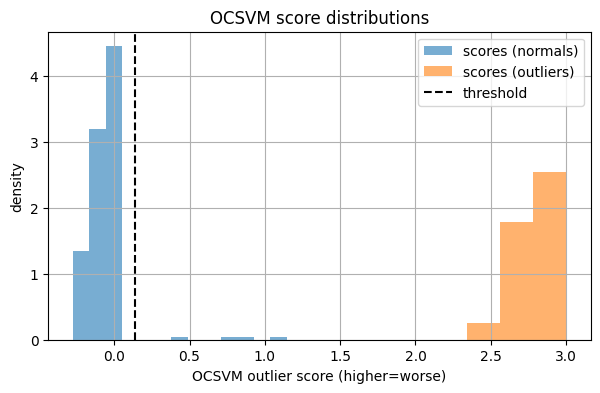

In [8]:
# ===== 可視化：散布図＋等高線 =====
x_min, y_min = (np.min(np.vstack([train,test]), axis=0) - 2)
x_max, y_max = (np.max(np.vstack([train,test]), axis=0) + 2)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_z = (grid - mu_hat)/std_hat

# 大きいほど異常スコア
def batched_decision(model, X, batch=5000):
    out = np.empty(X.shape[0], float)
    for i in range(0, X.shape[0], batch):
        out[i:i+batch] = -model.decision_function(X[i:i+batch]).ravel()
    return out

score_grid = batched_decision(ocsvm, grid_z, batch=4000).reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contour(xx, yy, score_grid, levels=[thr], linestyles='--', linewidths=2, colors='k')
plt.plot([], [], 'k--', label="threshold contour")
plt.scatter(train[:,0], train[:,1], s=8,  label="Train normal")
plt.scatter(test_norm[:,0], test_norm[:,1], s=18, marker='x', label="Test normal")
plt.scatter(test_out[:,0],  test_out[:,1],  s=30, marker='^', label="Test outlier (true)")
flag_idx = np.where(pred==1)[0]
plt.scatter(test[flag_idx,0], test[flag_idx,1], s=70, facecolors='none', edgecolors='red',
            linewidths=2, label="Predicted outlier")
plt.title("One-Class SVM anomaly detection (2D)\nContour = threshold on OCSVM score")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

# ===== スコアのヒスト =====
s_norm = score_test[(labels==0)&np.isfinite(score_test)]
s_out  = score_test[(labels==1)&np.isfinite(score_test)]
if len(s_norm)==0 and len(s_out)==0:
    print("（可視化できる有効なスコアがありませんでした）")
else:
    lo = np.nanpercentile(score_test, 0.5); hi = np.nanpercentile(score_test, 99.5)
    plt.figure(figsize=(7,4))
    plt.hist(s_norm, bins=30, density=True, alpha=0.6, label="scores (normals)", range=(lo,hi))
    plt.hist(s_out,  bins=15, density=True, alpha=0.6, label="scores (outliers)", range=(lo,hi))
    plt.axvline(min(max(thr,lo),hi), linestyle='--', color='k', label="threshold")
    plt.title("OCSVM score distributions"); plt.xlabel("OCSVM outlier score (higher=worse)")
    plt.ylabel("density"); plt.legend(); plt.grid(True); plt.show()
